In [25]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seqdata as sd
from eugene import plot as pl
import sys
sys.path.append('/cellar/users/aklie/projects/ML4GLand/collabs/er_stress_regulation/scripts')
from DeepMEL import DeepMEL

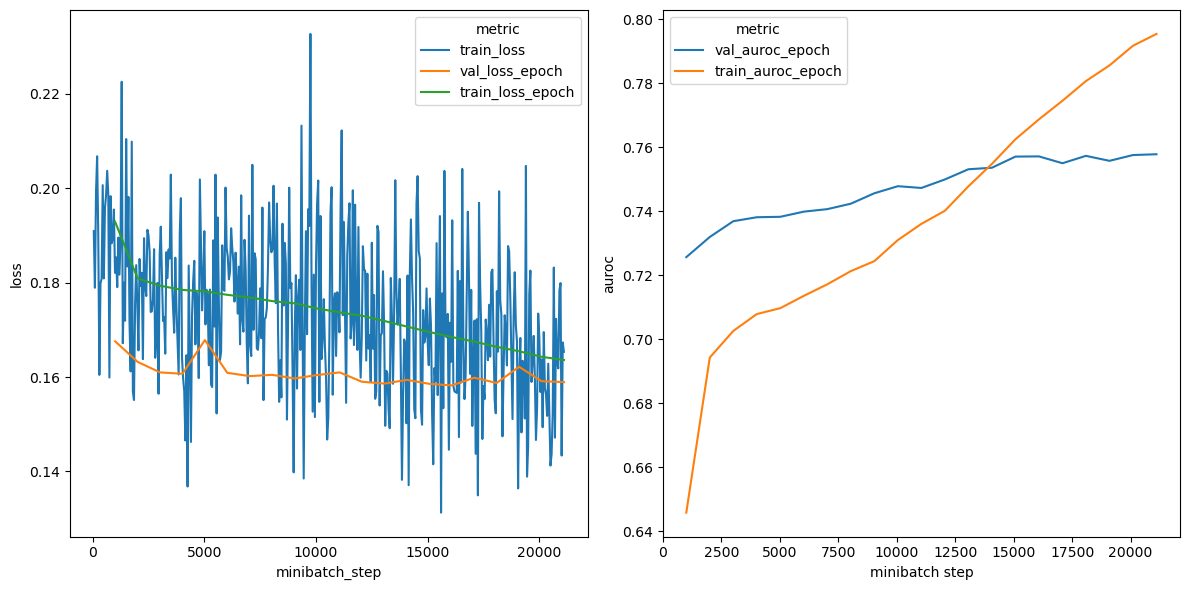

In [13]:
pl.training_summary("/cellar/users/aklie/projects/ML4GLand/collabs/er_stress_regulation/models/multiome_cells_all_peaks/multiome_cells_all_peaks.DeepMEL.revision/v0", metric="auroc")

In [32]:
dataset_name = "multiome_cells_all_peaks"
data_dir = f"/cellar/users/aklie/data/ml4gland/collabs/er_stress_regulation/{dataset_name}"
models_dir = "/cellar/users/aklie/projects/ML4GLand/collabs/er_stress_regulation/models"

# Load some data

In [16]:
sdata = sdata = sd.open_zarr(os.path.join(data_dir, f"{dataset_name}.train.zarr"))
train_sdata = sdata.sel(_sequence=(sdata["train_val"] == True).compute())  # noqa
val_sdata = sdata.sel(_sequence=(sdata["train_val"] == False).compute())  # noqa
test_sdata = sd.open_zarr(os.path.join(data_dir, f"{dataset_name}.test.zarr"))

In [21]:
train_sdata["topics"].values.sum(axis=0)/train_sdata["topics"].values.shape[0]

array([0.04696886, 0.05518297, 0.03775227, 0.06068495, 0.03845945,
       0.04643265, 0.05958922, 0.04378269, 0.04807236, 0.04157568,
       0.04706211, 0.0471476 , 0.05857897, 0.05205897, 0.05723456,
       0.0289087 , 0.04875623, 0.03912777, 0.05022497, 0.03957072,
       0.05175589, 0.064928  , 0.06065386, 0.05955036, 0.0759475 ,
       0.04501053, 0.0475517 , 0.04455203, 0.04020796, 0.043161  ,
       0.06370793, 0.04029344, 0.04201086, 0.04114049, 0.06261997,
       0.06419751, 0.04202641])

In [23]:
val_sdata["topics"].values.sum(axis=0)/val_sdata["topics"].values.shape[0]

array([0.0342225 , 0.05862283, 0.01861042, 0.07371795, 0.03639371,
       0.03566998, 0.05851944, 0.03463606, 0.04352771, 0.03670389,
       0.04818031, 0.05159222, 0.0530397 , 0.04580232, 0.03897849,
       0.02078164, 0.03970223, 0.03391232, 0.04073615, 0.03339537,
       0.04559553, 0.06172457, 0.0624483 , 0.06699752, 0.08643507,
       0.03039702, 0.04507858, 0.03008685, 0.04487179, 0.03742763,
       0.05376344, 0.02874276, 0.03122415, 0.03008685, 0.07061621,
       0.06741108, 0.03360215])

In [24]:
test_sdata["topics"].values.sum(axis=0)/test_sdata["topics"].values.shape[0]

array([0.03237835, 0.05775352, 0.02701228, 0.0728513 , 0.03628922,
       0.04502046, 0.06075489, 0.03719873, 0.04483856, 0.03683492,
       0.04693042, 0.05093224, 0.05484311, 0.04711232, 0.04492951,
       0.02337426, 0.04101864, 0.03692588, 0.04638472, 0.03356071,
       0.05038654, 0.06703047, 0.06848568, 0.0634834 , 0.08258299,
       0.03565257, 0.04556617, 0.02919509, 0.04329241, 0.04092769,
       0.05438836, 0.0319236 , 0.0324693 , 0.03547067, 0.06721237,
       0.06502956, 0.03528877])

# Load a trained model

In [28]:
arch = DeepMEL(
    input_len=500, 
    output_dim=37,
    conv_kwargs={
        "conv_channels": [1024],  
    },
)

In [29]:
from eugene import models

In [35]:
models_dir

'/cellar/users/aklie/projects/ML4GLand/collabs/er_stress_regulation/models'

In [36]:
os.path.join(models_dir, dataset_name, "multiome_cells_all_peaks.DeepMEL.revision/v0/checkpoints/epoch=15-step=16080.ckpt")

'/cellar/users/aklie/projects/ML4GLand/collabs/er_stress_regulation/models/multiome_cells_all_peaks/multiome_cells_all_peaks.DeepMEL.revision/v0/checkpoints/epoch=15-step=16080.ckpt'

In [38]:
model

SequenceModule(
  (arch): DeepMEL(
    (conv1d_tower): Conv1DTower(
      (layers): Sequential(
        (0): Conv1d(4, 1024, kernel_size=(20,), stride=(1,), padding=valid)
        (1): ReLU()
        (2): MaxPool1d(kernel_size=20, stride=1, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (recurrent_block): RecurrentBlock(
      (layers): LSTM(1024, 128, batch_first=True, bidirectional=True)
    )
    (dense_block): DenseBlock(
      (layers): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.4, inplace=False)
        (3): Linear(in_features=256, out_features=37, bias=True)
      )
    )
  )
  (train_metric): MultilabelAUROC()
  (val_metric): MultilabelAUROC()
  (test_metric): MultilabelAUROC()
)

# Evaluate per topic performance

In [39]:
import torch

In [44]:
from eugene import preprocess as pp

In [40]:
train_sdata

<xarray.Dataset>
Dimensions:        (_sequence: 128681, length: 500, _ohe: 4, _topic: 37)
Dimensions without coordinates: _sequence, length, _ohe, _topic
Data variables:
    chr:start:end  (_sequence) object dask.array<chunksize=(24917,), meta=np.ndarray>
    chrom          (_sequence) <U5 dask.array<chunksize=(14592,), meta=np.ndarray>
    ohe_seqs       (_sequence, length, _ohe) uint8 dask.array<chunksize=(14592, 63, 1), meta=np.ndarray>
    seqs           (_sequence) object dask.array<chunksize=(24917,), meta=np.ndarray>
    topics         (_sequence, _topic) float64 dask.array<chunksize=(14592, 5), meta=np.ndarray>
    train_test     (_sequence) bool dask.array<chunksize=(128681,), meta=np.ndarray>
    train_val      (_sequence) bool dask.array<chunksize=(128681,), meta=np.ndarray>

In [41]:
val_sdata

<xarray.Dataset>
Dimensions:        (_sequence: 9672, length: 500, _ohe: 4, _topic: 37)
Dimensions without coordinates: _sequence, length, _ohe, _topic
Data variables:
    chr:start:end  (_sequence) object dask.array<chunksize=(9672,), meta=np.ndarray>
    chrom          (_sequence) <U5 dask.array<chunksize=(2703,), meta=np.ndarray>
    ohe_seqs       (_sequence, length, _ohe) uint8 dask.array<chunksize=(2703, 63, 1), meta=np.ndarray>
    seqs           (_sequence) object dask.array<chunksize=(9672,), meta=np.ndarray>
    topics         (_sequence, _topic) float64 dask.array<chunksize=(2703, 5), meta=np.ndarray>
    train_test     (_sequence) bool dask.array<chunksize=(9672,), meta=np.ndarray>
    train_val      (_sequence) bool dask.array<chunksize=(9672,), meta=np.ndarray>

In [42]:
test_sdata

<xarray.Dataset>
Dimensions:        (_sequence: 10995, length: 500, _ohe: 4, _topic: 37)
Dimensions without coordinates: _sequence, length, _ohe, _topic
Data variables:
    chr:start:end  (_sequence) object dask.array<chunksize=(10995,), meta=np.ndarray>
    chrom          (_sequence) <U5 dask.array<chunksize=(10995,), meta=np.ndarray>
    ohe_seqs       (_sequence, length, _ohe) uint8 dask.array<chunksize=(2749, 125, 2), meta=np.ndarray>
    seqs           (_sequence) object dask.array<chunksize=(10995,), meta=np.ndarray>
    topics         (_sequence, _topic) float64 dask.array<chunksize=(2749, 19), meta=np.ndarray>
    train_test     (_sequence) bool dask.array<chunksize=(10995,), meta=np.ndarray>

In [51]:
model.to("cuda")

SequenceModule(
  (arch): DeepMEL(
    (conv1d_tower): Conv1DTower(
      (layers): Sequential(
        (0): Conv1d(4, 1024, kernel_size=(20,), stride=(1,), padding=valid)
        (1): ReLU()
        (2): MaxPool1d(kernel_size=20, stride=1, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (recurrent_block): RecurrentBlock(
      (layers): LSTM(1024, 128, batch_first=True, bidirectional=True)
    )
    (dense_block): DenseBlock(
      (layers): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.4, inplace=False)
        (3): Linear(in_features=256, out_features=37, bias=True)
      )
    )
  )
  (train_metric): MultilabelAUROC()
  (val_metric): MultilabelAUROC()
  (test_metric): MultilabelAUROC()
)

In [56]:
train_preds = model.predict(train_sdata["ohe_seqs"].transpose("_sequence", "_ohe", "length").values, batch_size=512)

Predicting on batches:   0%|          | 0/251 [00:00<?, ?it/s]

In [57]:
val_preds= model.predict(val_sdata["ohe_seqs"].transpose("_sequence", "_ohe", "length").values, batch_size=512)

Predicting on batches:   0%|          | 0/18 [00:00<?, ?it/s]

In [58]:
test_preds = model.predict(test_sdata["ohe_seqs"].transpose("_sequence", "_ohe", "length").values, batch_size=512)

Predicting on batches:   0%|          | 0/21 [00:00<?, ?it/s]

In [59]:
train_preds.shape, val_preds.shape, test_preds.shape

(torch.Size([128681, 37]), torch.Size([9672, 37]), torch.Size([10995, 37]))

In [60]:
train_preds = train_preds.cpu().numpy()
val_preds = val_preds.cpu().numpy()
test_preds = test_preds.cpu().numpy()

In [62]:
train_trues = train_sdata["topics"].values
val_trues = val_sdata["topics"].values
test_trues = test_sdata["topics"].values

In [63]:
train_preds.shape, train_trues.shape, val_preds.shape, val_trues.shape, test_preds.shape, test_trues.shape

((128681, 37), (128681, 37), (9672, 37), (9672, 37), (10995, 37), (10995, 37))

In [75]:
from eval import shuffle_label, calculate_roc_pr, evaluate_model

In [65]:
print('calculate roc and pr...')
roc_pr_dict = {"train": {}, "val": {}, "test": {}, "shuffle": {}}
roc_pr_dict["train"]["score"] = train_preds
roc_pr_dict["train"]["label"] = train_trues
roc_pr_dict["val"]["score"] = val_preds
roc_pr_dict["val"]["label"] = val_trues
roc_pr_dict["test"]["score"] = test_preds
roc_pr_dict["test"]["label"] = test_trues
roc_pr_dict["shuffle"]["score"] = np.array(roc_pr_dict["train"]["score"], copy=True)
roc_pr_dict["shuffle"]["label"] = shuffle_label(np.array(train_trues, copy=True))

calculate roc and pr...


In [68]:
for sets in ["train", "val", "test", "shuffle"]:
    roc_pr_dict[sets]["roc_pr"] = calculate_roc_pr(roc_pr_dict[sets]["score"], roc_pr_dict[sets]["label"])

In [69]:
roc_pr_dict["train"]["roc_pr"].T[0]

array([0.82440309, 0.70496368, 0.91187915, 0.70143317, 0.685296  ,
       0.85729704, 0.7680916 , 0.76963098, 0.75556585, 0.81348942,
       0.74510181, 0.7340734 , 0.67319182, 0.79460507, 0.74464384,
       0.97954166, 0.76875839, 0.96761593, 0.82217725, 0.94308457,
       0.72529387, 0.67259503, 0.83658623, 0.68378008, 0.61063472,
       0.91237375, 0.77135482, 0.87739701, 0.79556514, 0.8201907 ,
       0.75323502, 0.81690504, 0.87941572, 0.91303938, 0.71643676,
       0.64589803, 0.93697722])

In [70]:
roc_pr_dict["val"]["roc_pr"].T[0]

array([0.82027387, 0.6333373 , 0.92607693, 0.64999443, 0.64489398,
       0.86922088, 0.80233143, 0.74126689, 0.66131286, 0.70098608,
       0.65265655, 0.63787566, 0.64657097, 0.70860109, 0.76677259,
       0.97059103, 0.72354912, 0.95025241, 0.75220118, 0.94293756,
       0.64599922, 0.59630716, 0.86380588, 0.65565069, 0.61915851,
       0.92113544, 0.70353568, 0.88545869, 0.7298765 , 0.72785011,
       0.74899801, 0.73364293, 0.88823673, 0.90329287, 0.64162437,
       0.62194119, 0.92527821])

In [71]:
roc_pr_dict["test"]["roc_pr"].T[0]

array([0.80712552, 0.64474919, 0.90148793, 0.6318921 , 0.67421574,
       0.85349322, 0.75748097, 0.76072817, 0.6721967 , 0.74347148,
       0.67652673, 0.66119712, 0.63873401, 0.73112551, 0.74588057,
       0.96403152, 0.72160437, 0.95356065, 0.74127736, 0.92874179,
       0.64909771, 0.60692452, 0.85231663, 0.65880561, 0.62612092,
       0.90608309, 0.71475545, 0.87581727, 0.70264571, 0.75370813,
       0.74763929, 0.7659792 , 0.8678718 , 0.90126887, 0.6353556 ,
       0.60035353, 0.93439826])

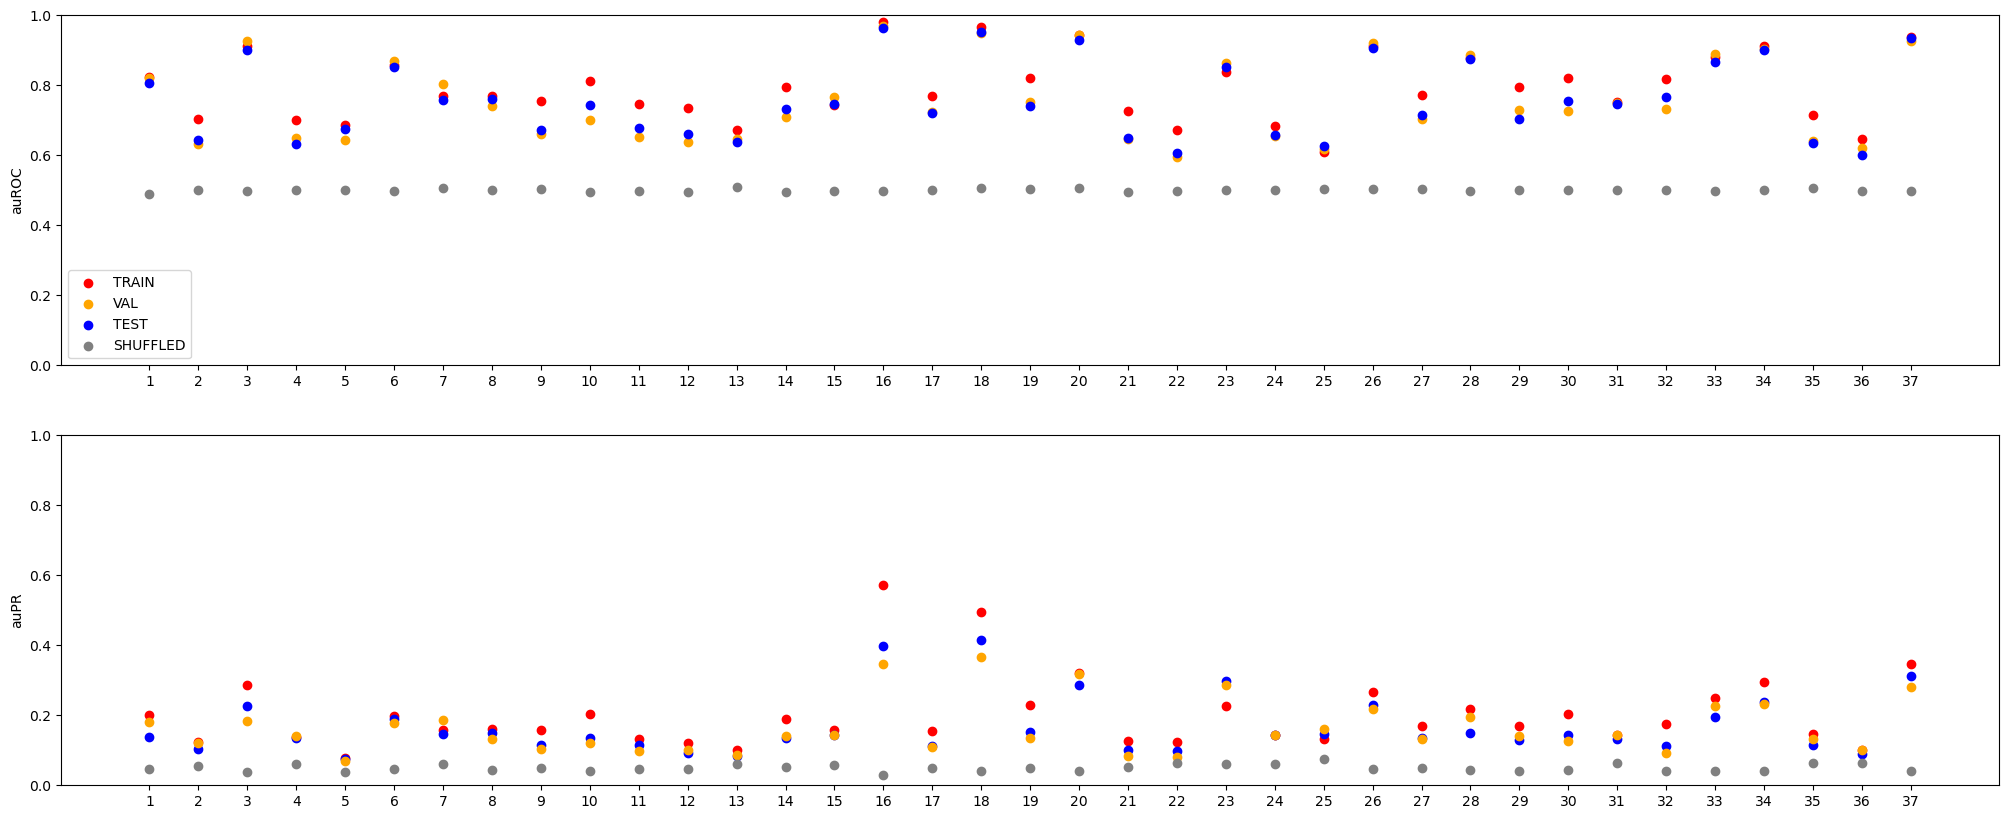

In [73]:


fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(2, 1, 1)
ax.set_ylabel('auROC')
ax.scatter(list(range(37)), roc_pr_dict["train"]["roc_pr"].T[0], color='red', label='TRAIN')
ax.scatter(list(range(37)), roc_pr_dict["val"]["roc_pr"].T[0], color='orange', label='VAL')
ax.scatter(list(range(37)), roc_pr_dict["test"]["roc_pr"].T[0], color='blue', label='TEST')
ax.scatter(list(range(37)), roc_pr_dict["shuffle"]["roc_pr"].T[0], color='gray', label='SHUFFLED')
ax.set_ylim([0, 1])
_ = plt.xticks(range(37),range(1,38))
ax.legend()

ax = fig.add_subplot(2, 1, 2)
ax.set_ylabel('auPR')
ax.scatter(list(range(37)), roc_pr_dict["train"]["roc_pr"].T[1], color='red', label='TRAIN')
ax.scatter(list(range(37)), roc_pr_dict["test"]["roc_pr"].T[1], color='blue', label='TEST')
ax.scatter(list(range(37)), roc_pr_dict["val"]["roc_pr"].T[1], color='orange', label='VAL')
ax.scatter(list(range(37)), roc_pr_dict["shuffle"]["roc_pr"].T[1], color='gray', label='SHUFFLED')
ax.set_ylim([0, 1])
_ = plt.xticks(range(37),range(1,38))

In [76]:
evaluate_model(train_trues, train_preds)

Test AUROC: 0.7928 +/- 0.0934
Test AUPR : 0.2004 +/- 0.1010


(array([0.82440309, 0.70496368, 0.91187915, 0.70143317, 0.685296  ,
        0.85729704, 0.7680916 , 0.76963098, 0.75556585, 0.81348942,
        0.74510181, 0.7340734 , 0.67319182, 0.79460507, 0.74464384,
        0.97954166, 0.76875839, 0.96761593, 0.82217725, 0.94308457,
        0.72529387, 0.67259503, 0.83658623, 0.68378008, 0.61063472,
        0.91237375, 0.77135482, 0.87739701, 0.79556514, 0.8201907 ,
        0.75323502, 0.81690504, 0.87941572, 0.91303938, 0.71643676,
        0.64589803, 0.93697722]),
 array([0.20012117, 0.12401252, 0.28721539, 0.13808477, 0.07772593,
        0.19746994, 0.15776493, 0.16062732, 0.15677787, 0.20425113,
        0.13358065, 0.12098287, 0.10150244, 0.18955631, 0.15884096,
        0.57257604, 0.15621634, 0.49424741, 0.22809377, 0.32053209,
        0.12764561, 0.12267215, 0.22651975, 0.14428057, 0.13200179,
        0.26702491, 0.16941861, 0.21777639, 0.16839228, 0.20280566,
        0.14373712, 0.17422478, 0.24803409, 0.2944232 , 0.14692216,
        0.1007

In [77]:
evaluate_model(val_trues, val_preds)

Test AUROC: 0.7571 +/- 0.1143
Test AUPR : 0.1631 +/- 0.0744


(array([0.82027387, 0.6333373 , 0.92607693, 0.64999443, 0.64489398,
        0.86922088, 0.80233143, 0.74126689, 0.66131286, 0.70098608,
        0.65265655, 0.63787566, 0.64657097, 0.70860109, 0.76677259,
        0.97059103, 0.72354912, 0.95025241, 0.75220118, 0.94293756,
        0.64599922, 0.59630716, 0.86380588, 0.65565069, 0.61915851,
        0.92113544, 0.70353568, 0.88545869, 0.7298765 , 0.72785011,
        0.74899801, 0.73364293, 0.88823673, 0.90329287, 0.64162437,
        0.62194119, 0.92527821]),
 array([0.17996507, 0.11974791, 0.18247939, 0.13985007, 0.06929142,
        0.17866922, 0.18603073, 0.13345187, 0.10477677, 0.12022309,
        0.09924468, 0.09943625, 0.08564905, 0.14055688, 0.14441891,
        0.34728741, 0.10895804, 0.36571741, 0.13478207, 0.31811613,
        0.08374028, 0.08155639, 0.28766469, 0.14375408, 0.16184684,
        0.21771844, 0.13268366, 0.19479512, 0.14116337, 0.12519244,
        0.14257368, 0.09250224, 0.22614836, 0.23204142, 0.13153638,
        0.1015

In [78]:
evaluate_model(test_trues, test_preds)

Test AUROC: 0.7570 +/- 0.1082
Test AUPR : 0.1654 +/- 0.0814


(array([0.80712552, 0.64474919, 0.90148793, 0.6318921 , 0.67421574,
        0.85349322, 0.75748097, 0.76072817, 0.6721967 , 0.74347148,
        0.67652673, 0.66119712, 0.63873401, 0.73112551, 0.74588057,
        0.96403152, 0.72160437, 0.95356065, 0.74127736, 0.92874179,
        0.64909771, 0.60692452, 0.85231663, 0.65880561, 0.62612092,
        0.90608309, 0.71475545, 0.87581727, 0.70264571, 0.75370813,
        0.74763929, 0.7659792 , 0.8678718 , 0.90126887, 0.6353556 ,
        0.60035353, 0.93439826]),
 array([0.1368635 , 0.10442697, 0.22667358, 0.13515541, 0.07449773,
        0.19065591, 0.14784542, 0.14950215, 0.11624065, 0.13506107,
        0.11407712, 0.09339288, 0.08354761, 0.13619566, 0.14356172,
        0.39789214, 0.11333948, 0.41457184, 0.15213578, 0.28607885,
        0.10101553, 0.0982962 , 0.29732044, 0.14280836, 0.14688754,
        0.22868211, 0.13569634, 0.14907141, 0.12923131, 0.14403719,
        0.13295508, 0.11207166, 0.19498097, 0.23857006, 0.11506073,
        0.0905

---

# Scratch